In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive.
FOLDERNAME = 'readmission'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Change directory.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/readmission


In [ ]:
### Import packages.
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#%matplotlib inline 
#import seaborn as sns
#import os
#from sklearn.ensemble import RandomForestClassifier

seed = 212

# systems
import os
import sys

# basic data processing
import numpy as np
np.random.seed(seed) # sklearn's random seed is the same as np.random.seed
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import itertools as it
from pprint import pprint

# ML-related (e.g. models, stats)
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import tensorflow
import keras
#import tensorflow as tf

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [20, 8]
import seaborn as sns
sns.set(font_scale=1.2)

In [ ]:
# Load data
starr = pd.read_csv('starr.csv', header = 0)
mimic = pd.read_csv('mimic.csv', header = 0)

print('starr: ', starr.shape)
print('mimic: ', mimic.shape)

starr:  (3107, 120)
mimic:  (13841, 120)


In [ ]:
# to make sure features from MIMIC and STARR dataframes are in the same order
# remove last lipase, last fio2.
feature_order = ['age', 'gender', 'ethnicity', 'icu_los', 'hospital_los', 'admit_ed', 
                 'ecg', 'xray', 'cxr', 'mri', 'ct', 'intub_days', 'extub_hrs', 
                 'diuretics', 'antihypertensives', 'inotrope_pressor', 'sedatives', 
                 'alt_last', 'ast_last', 'hco3_last', 'bnp_last', 'bun_last', 'ck_last', 'cr_last', 'crp_last', 
                 'dbili_last', 'esr_last', 'fio2_last', 'inr_last', 'hr_last', 'k_last', 'lac_last', 'ph_last', 
                 'lipase_last', 'na_last', 'map_last', 'pao2_last', 'paco2_last', 'plt_last', 'rr_last', 'sao2_last', 
                 'spo2_last', 'temp_last', 'tbili_last', 'wbc_last', 'trop_last', 'hgb_last', 'gcs_last', 'pafio2_last',
                 'alt_max', 'ast_max', 'hco3_max', 'bnp_max', 'bun_max', 'ck_max', 'cr_max', 'crp_max', 'esr_max', 
                 'dbili_max', 'hr_max', 'k_max', 'inr_max', 'cortisol_max', 'lipase_max', 'lac_max', 'map_max', 'ph_max',
                 'na_max', 'paco2_max', 'pao2_max', 'rr_max', 'spo2_max', 'sao2_max', 'tbili_max', 'trop_max', 'temp_max',
                 'wbc_max', 'gcs_max', 'gcs_min', 'hco3_min', 'cortisol_min', 'hr_min', 'inr_min', 'k_min', 'map_min', 'ph_min', 
                 'na_min', 'paco2_min', 'pao2_min', 'plt_min', 'rr_min', 'spo2_min', 'sao2_min', 'temp_min', 'wbc_min', 
                 'hgb_min', 'hco3_high', 'bnp_high', 'bun_high', 'inflamm_marker', 'glu_high', 'hr_high', 'k_high', 'na_high', 
                 'lac_high', 'temp_high', 'trop_high', 'wbc_high', 'map_high', 'hco3_low', 'hgb_low', 'map_low', 'hr_low', 'k_low', 
                 'plt_low', 'na_low', 'wbc_low', 'temp_low']

In [ ]:
starr_x = starr[feature_order]
starr_y = starr['readmit']
starr_x.head()

In [ ]:
mimic_x = mimic[feature_order]
mimic_y = starr['readmit']
mimic_x.head()

### Imputation

In [ ]:
starr.isna().sum()

In [ ]:
mimic.isna().sum()

In [ ]:
starr.describe()

In [ ]:
# For values of 9999999.0, make NA
# alt_last, hco3_last, ph_last, trop_last, fio2_last, pao2_last, paco2_last, sao2_last 9999999
print("number of 9999999.0 values: %d" % sum(starr.alt_last == 9999999.0))
starr.alt_last = np.where(starr.alt_last == 9999999.0, np.nan, starr.alt_last)
starr.alt_last.value_counts()
starr.alt_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.hco3_last == 9999999.0))
starr.hco3_last = np.where(starr.hco3_last == 9999999.0, np.nan, starr.hco3_last)
starr.hco3_last.value_counts()
starr.hco3_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.ph_last == 9999999.0))
starr.ph_last = np.where(starr.ph_last == 9999999.0, np.nan, starr.ph_last)
starr.ph_last.value_counts()
starr.ph_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.trop_last == 9999999.0))
starr.trop_last = np.where(starr.trop_last == 9999999.0, np.nan, starr.trop_last)
starr.trop_last.value_counts()
starr.trop_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.fio2_last == 9999999.0))
starr.fio2_last = np.where(starr.fio2_last == 9999999.0, np.nan, starr.fio2_last)
starr.fio2_last.value_counts()
starr.fio2_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.pao2_last == 9999999.0))
starr.pao2_last = np.where(starr.pao2_last == 9999999.0, np.nan, starr.pao2_last)
starr.pao2_last.value_counts()
starr.pao2_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.paco2_last == 9999999.0))
starr.paco2_last = np.where(starr.paco2_last == 9999999.0, np.nan, starr.paco2_last)
starr.paco2_last.value_counts()
starr.paco2_last.isna().sum()

print("number of 9999999.0 values: %d" % sum(starr.sao2_last == 9999999.0))
starr.sao2_last = np.where(starr.sao2_last == 9999999.0, np.nan, starr.sao2_last)
starr.sao2_last.value_counts()
starr.sao2_last.isna().sum()

In [ ]:
# hr_last 0; temp_last 36.8; map_last negative; wbc_max 34000k; temp_max 145.4; 
# hr_max 7576; map_max 941; map_min 314; map_min -40; extub_hrs no negatives 

# For values of hr_last < 10, make NA
starr.hr_last.value_counts().sort_index(ascending = False) #.sort_values(ascending = False)
print("number of patients with hr_last < 10: %d" % sum(starr.hr_last < 10))
starr.hr_last = np.where(starr.hr_last < 10, np.nan, starr.hr_last)

# temp_last: 85.5 (1), 60.8 (1), 45.0 (1), 36.8 (1); clinically possible...
starr.temp_last.value_counts().sort_index(ascending = False)

# For values of map_last < 0, make NA
starr.map_last.value_counts().sort_index(ascending = False)
print("number of patients with map_last < 0: %d" % sum(starr.map_last < 0))
starr.map_last = np.where(starr.map_last < 0, np.nan, starr.map_last)

# For values of wbc_max > 1k, divide by 1k
starr.wbc_max.value_counts().sort_index(ascending = False)
print("number of patients with wbc_max > 1k: %d" % sum(starr.wbc_max > 1000))
starr.wbc_max = np.where(starr.wbc_max > 1000, starr.wbc_max/1000, starr.wbc_max)

# For values of temp_max > 115F, make NA.
starr.temp_max.value_counts().sort_index(ascending = False)
print("number of patients with temp_max > 115F: %d" % sum(starr.temp_max > 115))
starr.temp_max = np.where(starr.temp_max > 115, np.nan, starr.temp_max)

# For values of hr_max >= 400bpm, make NA.
starr.hr_max.value_counts().sort_index(ascending = False)
print("number of patients with hr_max >= 400bpm: %d" % sum(starr.hr_max >= 400))
starr.hr_max = np.where(starr.hr_max >= 400, np.nan, starr.hr_max)

# For values map_max >= 400, make NA.
starr.map_max.value_counts().sort_index(ascending = False)
print("number of patients with map_max >= 400: %d" % sum(starr.map_max >= 400))
starr.map_max = np.where(starr.map_max >= 400, np.nan, starr.map_max)

# For values of map_min < 0, make NA
starr.map_min.value_counts().sort_index(ascending = False)
print("number of patients with map_min < 0: %d" % sum(starr.map_min < 0))
starr.map_min = np.where(starr.map_min < 0, np.nan, starr.map_min)

# For values of extub_hrs < 0, make NA
starr.extub_hrs.value_counts().sort_index(ascending = False)
print("number of patients with extub_hrs < 0: %d" % sum(starr.extub_hrs < 0))
starr.extub_hrs = np.where(starr.extub_hrs < 0, np.nan, starr.extub_hrs)


In [ ]:
# For values of fio2_last <= 21, make NA. Change fio2 values from % to decimal.
starr.fio2_last.describe()
print("number of patients with fio2_last <= 21: %d" % sum(starr.fio2_last <= 21))
starr.fio2_last = np.where(starr.fio2_last <= 21, np.nan, starr.fio2_last)
starr.fio2_last = starr.fio2_last/100


number of patients with fio2_last <= 21: 572


In [ ]:
starr.pao2_last.describe()

In [ ]:
# recalc pafio2_last
starr.fio2_last.describe()
starr.pafio2_last = starr.pao2_last/starr.fio2_last
starr.pafio2_last.describe()

In [ ]:
starr.intub_days.isna().sum()
starr.intub_days.fillna(0)

starr.extub_hrs.isna().sum()
starr.extub_hrs = starr.extub_hrs.fillna(0)


In [ ]:
mimic.describe()

In [ ]:
# bnp_last, inr_last, lac_last, ph_last, paco2_last, pao2_last, sao2_last, hco3_max, bnp_max, bun_max, cr_max, inr_max, k_max, lac_max, na_max, 
# ph_max, paco2_max, pao2_max, sao2_max, wbc_max, inr_min, ph_min, paco2_min, pao2_min, sao2_min, 999999; 

# For values of 999999.0, make NA.
# bnp_last
print("number of 999999.0 values: %d" % sum(mimic.bnp_last == 999999.0))
mimic.bnp_last = np.where(mimic.bnp_last == 999999.0, np.nan, mimic.bnp_last)
mimic.bnp_last.value_counts()
mimic.bnp_last.isna().sum()

# inr_last
print("number of 999999.0 values: %d" % sum(mimic.inr_last == 999999.0))
mimic.inr_last = np.where(mimic.inr_last == 999999.0, np.nan, mimic.inr_last)

# lac_last
print("number of 999999.0 values: %d" % sum(mimic.lac_last == 999999.0))
mimic.lac_last = np.where(mimic.lac_last == 999999.0, np.nan, mimic.lac_last)

# ph_last
print("number of 999999.0 values: %d" % sum(mimic.ph_last == 999999.0))
mimic.ph_last = np.where(mimic.ph_last == 999999.0, np.nan, mimic.ph_last)

# paco2_last
print("number of 999999.0 values: %d" % sum(mimic.paco2_last == 999999.0))
mimic.paco2_last = np.where(mimic.paco2_last == 999999.0, np.nan, mimic.paco2_last)

# pao2_last
print("number of 999999.0 values: %d" % sum(mimic.pao2_last == 999999.0))
mimic.pao2_last = np.where(mimic.pao2_last == 999999.0, np.nan, mimic.pao2_last)

# sao2_last
print("number of 999999.0 values: %d" % sum(mimic.sao2_last == 999999.0))
mimic.sao2_last = np.where(mimic.sao2_last == 999999.0, np.nan, mimic.sao2_last)

# hco3_max
print("number of 999999.0 values: %d" % sum(mimic.hco3_max == 999999.0))
mimic.hco3_max = np.where(mimic.hco3_max == 999999.0, np.nan, mimic.hco3_max)

# bnp_max
print("number of 999999.0 values: %d" % sum(mimic.bnp_max == 999999.0))
mimic.bnp_max = np.where(mimic.bnp_max == 999999.0, np.nan, mimic.bnp_max)

# bun_max
print("number of 999999.0 values: %d" % sum(mimic.bun_max == 999999.0))
mimic.bun_max = np.where(mimic.bun_max == 999999.0, np.nan, mimic.bun_max)

# cr_max
print("number of 999999.0 values: %d" % sum(mimic.cr_max == 999999.0))
mimic.cr_max = np.where(mimic.cr_max == 999999.0, np.nan, mimic.cr_max)

# inr_max
print("number of 999999.0 values: %d" % sum(mimic.inr_max == 999999.0))
mimic.inr_max = np.where(mimic.inr_max == 999999.0, np.nan, mimic.inr_max)

# k_max
print("number of 999999.0 values: %d" % sum(mimic.k_max == 999999.0))
mimic.k_max = np.where(mimic.k_max == 999999.0, np.nan, mimic.k_max)

# lac_max
print("number of 999999.0 values: %d" % sum(mimic.lac_max == 999999.0))
mimic.lac_max = np.where(mimic.lac_max == 999999.0, np.nan, mimic.lac_max)

# na_max
print("number of 999999.0 values: %d" % sum(mimic.na_max == 999999.0))
mimic.na_max = np.where(mimic.na_max == 999999.0, np.nan, mimic.na_max)

# ph_max
print("number of 999999.0 values: %d" % sum(mimic.ph_max == 999999.0))
mimic.ph_max = np.where(mimic.ph_max == 999999.0, np.nan, mimic.ph_max)

# paco2_max
print("number of 999999.0 values: %d" % sum(mimic.paco2_max == 999999.0))
mimic.paco2_max = np.where(mimic.paco2_max == 999999.0, np.nan, mimic.paco2_max)

# pao2_max
print("number of 999999.0 values: %d" % sum(mimic.pao2_max == 999999.0))
mimic.pao2_max = np.where(mimic.pao2_max == 999999.0, np.nan, mimic.pao2_max)

# sao2_max
print("number of 999999.0 values: %d" % sum(mimic.sao2_max == 999999.0))
mimic.sao2_max = np.where(mimic.sao2_max == 999999.0, np.nan, mimic.sao2_max)

# wbc_max
print("number of 999999.0 values: %d" % sum(mimic.wbc_max == 999999.0))
mimic.wbc_max = np.where(mimic.wbc_max == 999999.0, np.nan, mimic.wbc_max)

# inr_min
print("number of 999999.0 values: %d" % sum(mimic.inr_min == 999999.0))
mimic.inr_min = np.where(mimic.inr_min == 999999.0, np.nan, mimic.inr_min)

# ph_min
print("number of 999999.0 values: %d" % sum(mimic.ph_min == 999999.0))
mimic.ph_min = np.where(mimic.ph_min == 999999.0, np.nan, mimic.ph_min)

# paco2_min
print("number of 999999.0 values: %d" % sum(mimic.paco2_min == 999999.0))
mimic.paco2_min = np.where(mimic.paco2_min == 999999.0, np.nan, mimic.paco2_min)

# pao2_min
print("number of 999999.0 values: %d" % sum(mimic.pao2_min == 999999.0))
mimic.pao2_min = np.where(mimic.pao2_min == 999999.0, np.nan, mimic.pao2_min)

# sao2_min
print("number of 999999.0 values: %d" % sum(mimic.sao2_min == 999999.0))
mimic.sao2_min = np.where(mimic.sao2_min == 999999.0, np.nan, mimic.sao2_min)



In [ ]:
# Fix intub_days -4; fio2_last; 1000; hr_last 880; rr_last 280; spo2_last 333333; 

# For values of intub_days < 0, make NA. 
mimic.intub_days.value_counts().sort_index(ascending = False)
print("number of patients with intub_days < 0: %d" % sum(mimic.intub_days < 0))
mimic.intub_days = np.where(mimic.intub_days < 0, np.nan, mimic.intub_days)

# For values of fio2_last > 100, make NA. 
mimic.fio2_last.value_counts().sort_index(ascending = False)
print("number of patients with fio2_last > 100: %d" % sum(mimic.fio2_last > 100))
mimic.fio2_last = np.where(mimic.fio2_last > 100, np.nan, mimic.fio2_last)

# For values of hr_last >= 400, make NA. 
mimic.hr_last.value_counts().sort_index(ascending = False)
print("number of patients with hr_last >= 400: %d" % sum(mimic.hr_last >= 400))
mimic.hr_last = np.where(mimic.hr_last > 100, np.nan, mimic.hr_last)

# RR going to be removed. 
#mimic.rr_last.value_counts().sort_index(ascending = False)
#print("number of patients with hr_last >= 400: %d" % sum(mimic.hr_last >= 400))
#mimic.hr_last = np.where(mimic.hr_last > 100, np.nan, mimic.hr_last)

# For values of spo2_last > 100, make NA. 
mimic.spo2_last.value_counts().sort_index(ascending = False)
print("number of patients with hr_last > 100: %d" % sum(mimic.spo2_last > 100))
mimic.spo2_last = np.where(mimic.spo2_last > 100, np.nan, mimic.spo2_last)

# Fix hr_max 102115; rr_max 235556; spo2_max 636333; temp_max 999; 
# For values of hr_max >= 400, make NA. 
mimic.hr_max.value_counts().sort_index(ascending = False)
print("number of patients with hr_max >= 400: %d" % sum(mimic.hr_max >= 400))
mimic.hr_max = np.where(mimic.hr_max >= 400, np.nan, mimic.hr_max)

# For values of spo2_max > 100, make NA. 
mimic.spo2_max.value_counts().sort_index(ascending = False)
print("number of patients with spo2_max > 100: %d" % sum(mimic.spo2_max > 100))
mimic.spo2_max = np.where(mimic.spo2_max > 100, np.nan, mimic.spo2_max)

# For values of temp_max >= 115, make NA. 
mimic.temp_max.value_counts().sort_index(ascending = False)
print("number of patients with temp_max >= 115: %d" % sum(mimic.temp_max >= 115))
mimic.temp_max = np.where(mimic.temp_max >= 115, np.nan, mimic.temp_max)

# Fix rr_min -1; sao2_min 0; spo2_min -678; temp_min -18; 
# For values of spo2_min < 0, make NA. 
mimic.spo2_min.value_counts().sort_index(ascending = False)
print("number of patients with spo2_min < 0: %d" % sum(mimic.spo2_min < 0))
mimic.spo2_min = np.where(mimic.spo2_min < 0, np.nan, mimic.spo2_min)

# For values of temp_min < 0, make NA. Note: Lots in 30s and below, accidental recording in Celsius?
mimic.temp_min.value_counts().sort_index(ascending = False)
print("number of patients with temp_min < 0: %d" % sum(mimic.temp_min < 0))
mimic.temp_min = np.where(mimic.temp_min < 0, np.nan, mimic.temp_min)



In [ ]:
# For NA intub_days values, make 0.
mimic.intub_days = mimic.intub_days.fillna(0)
mimic.intub_days.isna().sum()

# For NA extub_hrs values, make 0.
mimic.extub_hrs = mimic.extub_hrs.fillna(0)
mimic.extub_hrs.isna().sum()



In [ ]:
# fio2_last
# For values of fio2_last <= 21, make NA. Change fio2 values from % to decimal.
mimic.fio2_last.describe()
print("number of patients with fio2_last <= 21: %d" % sum(mimic.fio2_last <= 21))
#print("number of patients with fio2_last <= 1: %d" % sum(mimic.fio2_last <= 1))
#mimic.fio2_last.loc[np.where(mimic.fio2_last <= 1)]
mimic.fio2_last = np.where(mimic.fio2_last <= 21, np.nan, mimic.fio2_last)
mimic.fio2_last = mimic.fio2_last/100


In [ ]:
mimic.fio2_last.describe()

In [ ]:
# pao2_last
mimic.pao2_last.describe()
mimic.pao2_last.value_counts().sort_index(ascending = False)
# For values of pao2_last >= 1000, make NA. 
print("number of patients with pao2_last >= 1000: %d" % sum(mimic.pao2_last >= 1000))
mimic.pao2_last = np.where(mimic.pao2_last > 100, np.nan, mimic.pao2_last)

# recalc pafio2_last
mimic.pafio2_last = mimic.pao2_last/mimic.fio2_last

In [ ]:
mimic.pafio2_last.describe()
mimic.pafio2_last.value_counts().sort_index(ascending = False)
mimic.pafio2_last.isna().sum()

In [ ]:
# Remove rr variables in starr and mimic.
# Fix low temps: C to F?

In [ ]:
# Remove features with > 50% missingness.
starr.isna().sum() > starr.shape[0]*0.5 # need to keep fio2_last and pafio2_last
mimic.isna().sum() > mimic.shape[0]*0.5 # need to keep pao2_last, pafio2_last


In [ ]:
# Create imputation cols.
def impute_cols(data):
  for col in list(data.columns):
    if data[col].isna().sum() > 0:
      col_name = col + '_imputed'
      data[col_name] = [1 if x >= 0 else 0 for x in data[col]]
  return data

In [ ]:
# Imputation marker columns: STARR.
starr_impute_cols = impute_cols(starr)
starr_impute_cols.describe()

In [ ]:
# Imputation marker columns: MIMIC.
mimic_impute_cols = impute_cols(mimic)
mimic_impute_cols.describe()

In [ ]:
# Mean imputation.
def impute_missing_values(data):
    for col in list(data.columns):
        if col in ("id", "readmit", "race"):
            continue

        print("column name: %s" % col)
        print("number of NaN values: %d" % data[col].isna().sum())
        print("imputation value (mean): %.3f" % data[col].mean())
        print()

        data[col] = data[col].fillna(data[col].mean())
        
    return data



In [ ]:
# Mean imputed data: STARR
starr_imputed = impute_missing_values(starr_impute_cols)
starr_imputed.describe()


In [ ]:
starr_imputed.isna().sum()

In [ ]:
# Mean imputed data: MIMIC
mimic_imputed = impute_missing_values(mimic_impute_cols)
mimic_imputed.describe()

In [ ]:
mimic_imputed.isna().sum()

In [ ]:
# Remove rr variables.
starr_imputed = starr_imputed.drop(['rr_last', 'rr_min', 'rr_max', 'rr_min_imputed', 'rr_max_imputed', 'rr_last_imputed'], axis = 1)
mimic_imputed = mimic_imputed.drop(['rr_last', 'rr_min', 'rr_max', 'rr_min_imputed', 'rr_max_imputed', 'rr_last_imputed'], axis = 1)

In [ ]:
starr.describe()

In [ ]:
mimic.describe()

### Model training and internal validation.

In [ ]:
# to make sure features from MIMIC and STARR dataframes are in the same order
# remove last lipase, last fio2.
feature_order = ['age', 'gender', 'ethnicity', 'icu_los', 'hospital_los', 'admit_ed', 
                 'ecg', 'xray', 'cxr', 'mri', 'ct', 'intub_days', 'extub_hrs', 
                 'diuretics', 'antihypertensives', 'inotrope_pressor', 'sedatives', 
                 'alt_last', 'ast_last', 'hco3_last', 'bnp_last', 'bun_last', 'ck_last', 'cr_last', 'crp_last', 
                 'dbili_last', 'esr_last', 'fio2_last', 'inr_last', 'hr_last', 'k_last', 'lac_last', 'ph_last', 
                 'lipase_last', 'na_last', 'map_last', 'pao2_last', 'paco2_last', 'plt_last', 'sao2_last', 
                 'spo2_last', 'temp_last', 'tbili_last', 'wbc_last', 'trop_last', 'hgb_last', 'gcs_last', 'pafio2_last',
                 'alt_max', 'ast_max', 'hco3_max', 'bnp_max', 'bun_max', 'ck_max', 'cr_max', 'crp_max', 'esr_max', 
                 'dbili_max', 'hr_max', 'k_max', 'inr_max', 'cortisol_max', 'lipase_max', 'lac_max', 'map_max', 'ph_max',
                 'na_max', 'paco2_max', 'pao2_max', 'spo2_max', 'sao2_max', 'tbili_max', 'trop_max', 'temp_max',
                 'wbc_max', 'gcs_max', 'gcs_min', 'hco3_min', 'cortisol_min', 'hr_min', 'inr_min', 'k_min', 'map_min', 'ph_min', 
                 'na_min', 'paco2_min', 'pao2_min', 'plt_min', 'spo2_min', 'sao2_min', 'temp_min', 'wbc_min', 
                 'hgb_min', 'hco3_high', 'bnp_high', 'bun_high', 'inflamm_marker', 'glu_high', 'hr_high', 'k_high', 'na_high', 
                 'lac_high', 'temp_high', 'trop_high', 'wbc_high', 'map_high', 'hco3_low', 'hgb_low', 'map_low', 'hr_low', 'k_low', 
                 'plt_low', 'na_low', 'wbc_low', 'temp_low']

In [ ]:
test_proportion = 0.2
# val_proportion is in relation to the train set
# that is 1.0 is the entire train set, not the entire data set
val_proportion = 0.25

X = starr_imputed.drop(columns=["id", "readmit"]).astype("float")
X = X[feature_order]
y = starr_imputed[["readmit"]]

# split into train+val and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_proportion, random_state=seed)

# split into train and val 
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=val_proportion, random_state=seed)

In [ ]:
X_train.describe()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

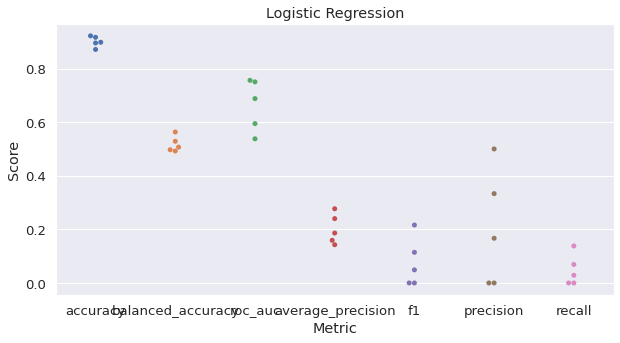

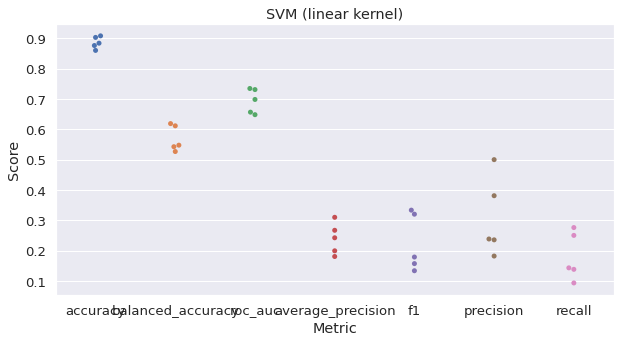

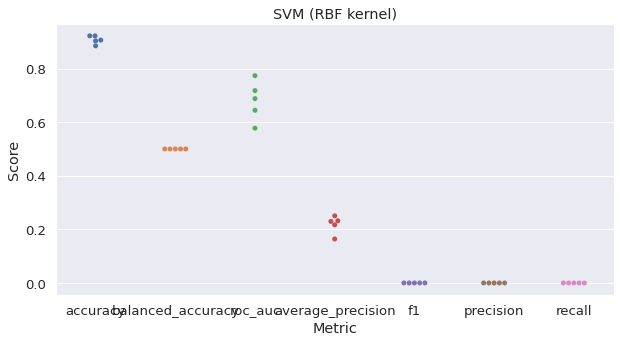

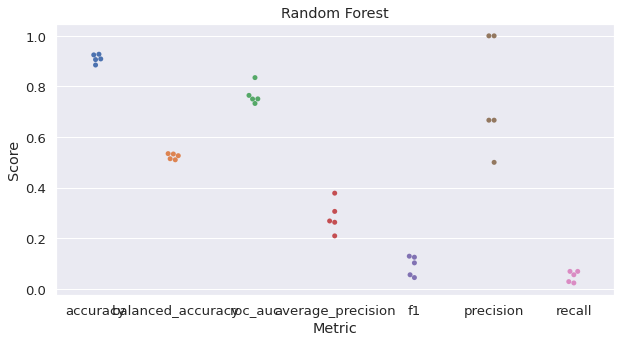

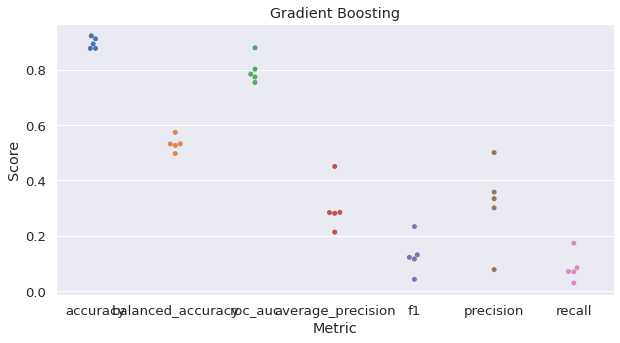

In [ ]:
k = 5
# types of scoring paramters 
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
metric = ["accuracy", "balanced_accuracy", "roc_auc", "average_precision", "f1", "precision", "recall"]

models = [("Logistic Regression", LogisticRegression()),
          ("SVM (linear kernel)", SVC(kernel="linear")),
          ("SVM (RBF kernel)", SVC()),
          ("Random Forest",  RandomForestClassifier()),
          ("Gradient Boosting", GradientBoostingClassifier())]
results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=k, shuffle=True, random_state=seed)
    scores = model_selection.cross_validate(model, X_train, y_train, scoring=metric, cv=kfold)
    results.append((name, scores))

fig_size = (10, 5)
for name, scores in results:
    scores_df = pd.DataFrame.from_dict(scores).drop(columns=["fit_time", "score_time"])
    scores_df.columns = [col[5:] for col in scores_df.columns]
    scores_df = pd.melt(scores_df, var_name="Metric", value_name="Score")
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=scores_df, x="Metric", y="Score")
    ax.set_title(name)
    plt.show()
    print("\n\n")

In [ ]:
results

[('Logistic Regression',
  {'fit_time': array([0.09990239, 0.11702251, 0.08448339, 0.16891718, 0.10991001]),
   'score_time': array([0.01755643, 0.01412129, 0.01555824, 0.01197171, 0.01929331]),
   'test_accuracy': array([0.89544236, 0.87131367, 0.89812332, 0.92204301, 0.91666667]),
   'test_average_precision': array([0.15904203, 0.27681944, 0.14264449, 0.24007101, 0.18625912]),
   'test_balanced_accuracy': array([0.50688926, 0.49242424, 0.49703264, 0.56313461, 0.52865185]),
   'test_f1': array([0.04878049, 0.        , 0.        , 0.21621622, 0.11428571]),
   'test_precision': array([0.16666667, 0.        , 0.        , 0.5       , 0.33333333]),
   'test_recall': array([0.02857143, 0.        , 0.        , 0.13793103, 0.06896552]),
   'test_roc_auc': array([0.59450549, 0.75616631, 0.53783383, 0.750377  , 0.68794611])}),
 ('SVM (linear kernel)',
  {'fit_time': array([ 660.16779447,  670.90709209, 1041.38997865, 1375.95890284,
           400.72163486]),
   'score_time': array([0.03788996, 

In [ ]:
metric = ["accuracy", "balanced_accuracy", "roc_auc", "average_precision", "f1", "precision", "recall"]
def validation_results(clf, X_val, y_val, name, results):
    y_pred = clf.predict(X_val)
    if "SVM" in name:
        y_score = clf.decision_function(X_val)
    else:
        y_score = clf.predict_proba(X_val)[:, 1]
    
    acc = metrics.accuracy_score(y_val, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_score)
    avg_prec = metrics.average_precision_score(y_val, y_score)
    f1 = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)     
    results[name] = {"accuracy": acc,
                     "balanced_accuracy": bal_acc,
                     "roc_auc": roc_auc,
                     "average_precision": avg_prec,
                     "f1": f1,
                     "precision": precision,
                     "recall": recall}
    
    return results

In [ ]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
penalties = ["l1", "l2"]
C_values = [100, 10, 1.0, 0.1, 0.01] # smaller values = stronger regularization

i = 0
results = {}
models = []
for solver, penalty, C in it.product(solvers, penalties, C_values):
    if solver in ["newton-cg", "sag", "lbfgs"] and penalty != "l2":
        # skip parameter configurations not supported by scikit-learn
        continue
        
    print("Model #{i} Hyperparameters => Solver: {s}, Penalty: {p}, C: {c}".format(i=i, s=solver, p=penalty, c=C))
    if solver in ["sag", "saga", "liblinear"]:
        # these solvers first shuffle the data, so include random seed
        model = LogisticRegression(solver=solver, penalty=penalty, C=C, random_state=seed)
    else:
        model = LogisticRegression(solver=solver, penalty=penalty, C=C)
    model.fit(X_train, y_train)
    models.append(model)
    results = validation_results(model, X_val, y_val, "Model #%d" % i, results)
    i += 1

Model #0 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #1 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #2 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #3 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #4 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local

Model #5 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 100
Model #6 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

Model #7 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 1.0
Model #8 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

Model #9 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 0.01
Model #10 Hyperparameters => Solver: liblinear, Penalty: l1, C: 100
Model #11 Hyperparameters => Solver: liblinear, Penalty: l1, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #12 Hyperparameters => Solver: liblinear, Penalty: l1, C: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #13 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #14 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #15 Hyperparameters => Solver: liblinear, Penalty: l2, C: 100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #16 Hyperparameters => Solver: liblinear, Penalty: l2, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #17 Hyperparameters => Solver: liblinear, Penalty: l2, C: 1.0
Model #18 Hyperparameters => Solver: liblinear, Penalty: l2, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #19 Hyperparameters => Solver: liblinear, Penalty: l2, C: 0.01
Model #20 Hyperparameters => Solver: sag, Penalty: l2, C: 100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column

Model #21 Hyperparameters => Solver: sag, Penalty: l2, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #22 Hyperparameters => Solver: sag, Penalty: l2, C: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #23 Hyperparameters => Solver: sag, Penalty: l2, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #24 Hyperparameters => Solver: sag, Penalty: l2, C: 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #25 Hyperparameters => Solver: saga, Penalty: l1, C: 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #26 Hyperparameters => Solver: saga, Penalty: l1, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #27 Hyperparameters => Solver: saga, Penalty: l1, C: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #28 Hyperparameters => Solver: saga, Penalty: l1, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #29 Hyperparameters => Solver: saga, Penalty: l1, C: 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #30 Hyperparameters => Solver: saga, Penalty: l2, C: 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #31 Hyperparameters => Solver: saga, Penalty: l2, C: 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #32 Hyperparameters => Solver: saga, Penalty: l2, C: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #33 Hyperparameters => Solver: saga, Penalty: l2, C: 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model #34 Hyperparameters => Solver: saga, Penalty: l2, C: 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_validation_results(results, model_name, fig_size=(10, 8)):
    results_df = pd.DataFrame()
    for name, result in results.items():
        results_df = results_df.append(result, ignore_index=True)

    results_df = pd.melt(results_df, var_name="Metric", value_name="Score")
    results_df["Name"] = list(results.keys()) * len(metric)

    ncol = (len(results.keys()) // 20) + 1
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=results_df, x="Metric", y="Score", hue="Name")
    ax.set_title("Performance of %s Models with Varied Hyperparameters" % model_name)
    plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right", ncol=ncol)
    plt.show()
    
    print("\n\n")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


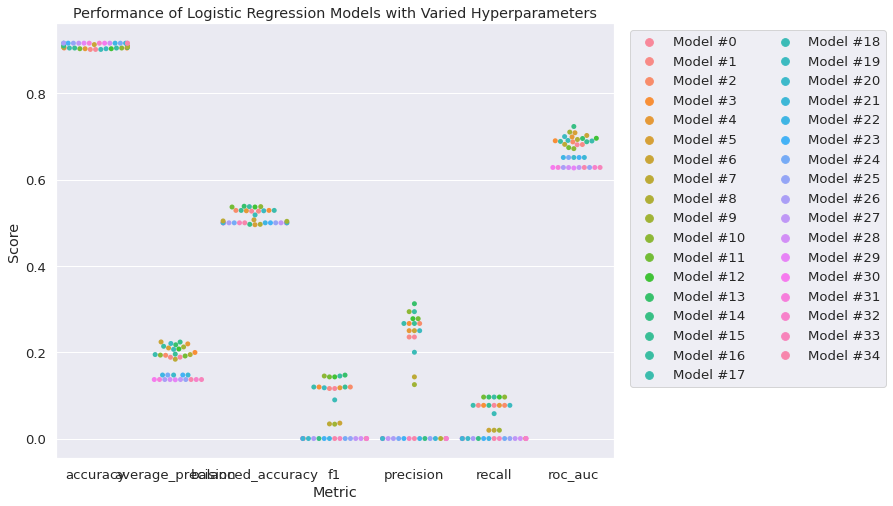

In [ ]:
plot_validation_results(results, "Logistic Regression")

In [ ]:
def filter_validation_results(results, metric_name, threshold):
    filtered_models = []
    for name, result in results.items():
        if result[metric_name] > threshold:
            print(name)
            filtered_models.append(name)
            
    return filtered_models

def find_models(filtered_results):
    for model_name in filtered_results:
        print(model_name)
        print(results[model_name])
        print()

In [ ]:
p_6 = filter_validation_results(results, "precision", 0.25)

Model #2
Model #3
Model #10
Model #11
Model #12
Model #13
Model #15
Model #16
Model #17


In [ ]:
find_models(p_6)

Model #2
{'accuracy': 0.905144694533762, 'balanced_accuracy': 0.528812415654521, 'roc_auc': 0.6876180836707152, 'average_precision': 0.19298315290168222, 'f1': 0.11940298507462686, 'precision': 0.26666666666666666, 'recall': 0.07692307692307693}

Model #3
{'accuracy': 0.905144694533762, 'balanced_accuracy': 0.528812415654521, 'roc_auc': 0.6901821862348179, 'average_precision': 0.19949889953954184, 'f1': 0.11940298507462686, 'precision': 0.26666666666666666, 'recall': 0.07692307692307693}

Model #10
{'accuracy': 0.905144694533762, 'balanced_accuracy': 0.5375506072874494, 'roc_auc': 0.6719635627530365, 'average_precision': 0.19339610154850978, 'f1': 0.14492753623188406, 'precision': 0.29411764705882354, 'recall': 0.09615384615384616}

Model #11
{'accuracy': 0.9035369774919614, 'balanced_accuracy': 0.5366734143049933, 'roc_auc': 0.6743589743589744, 'average_precision': 0.1913322358865595, 'f1': 0.14285714285714288, 'precision': 0.2777777777777778, 'recall': 0.09615384615384616}

Model #12

In [ ]:
p_5 = filter_validation_results(results, "precision", 0.3)

Model #13


In [ ]:
r_1 = filter_validation_results(results, "recall", 0.1)

In [ ]:
good_models = set(p_5).intersection(set(r_1))
find_models(good_models)

In [ ]:
f1_2 = filter_validation_results(results, "f1", 0.13)

Model #10
Model #11
Model #12
Model #13
Model #16


In [ ]:
find_models(f1_2)

Model #10
{'accuracy': 0.905144694533762, 'balanced_accuracy': 0.5375506072874494, 'roc_auc': 0.6719635627530365, 'average_precision': 0.19339610154850978, 'f1': 0.14492753623188406, 'precision': 0.29411764705882354, 'recall': 0.09615384615384616}

Model #11
{'accuracy': 0.9035369774919614, 'balanced_accuracy': 0.5366734143049933, 'roc_auc': 0.6743589743589744, 'average_precision': 0.1913322358865595, 'f1': 0.14285714285714288, 'precision': 0.2777777777777778, 'recall': 0.09615384615384616}

Model #12
{'accuracy': 0.9035369774919614, 'balanced_accuracy': 0.5366734143049933, 'roc_auc': 0.6959851551956815, 'average_precision': 0.2074872019693274, 'f1': 0.14285714285714288, 'precision': 0.2777777777777778, 'recall': 0.09615384615384616}

Model #13
{'accuracy': 0.9067524115755627, 'balanced_accuracy': 0.5384278002699056, 'roc_auc': 0.6954790823211876, 'average_precision': 0.2172892197090951, 'f1': 0.14705882352941177, 'precision': 0.3125, 'recall': 0.09615384615384616}

Model #16
{'accurac

In [ ]:
def plot_roc_pr_curves(X, y, clf, fig_size=(10, 8)):
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X, y, ax=ax)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic (ROC) Curve")
    plt.show()

    # PR Curve and AP (average precision)
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall (PR) Curve")
    plt.show()

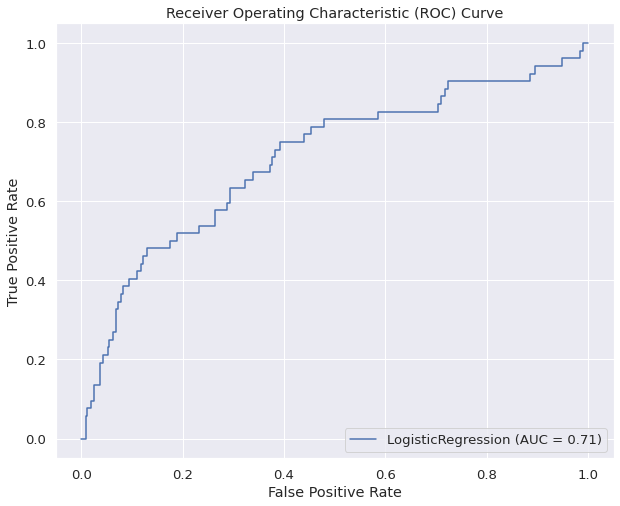

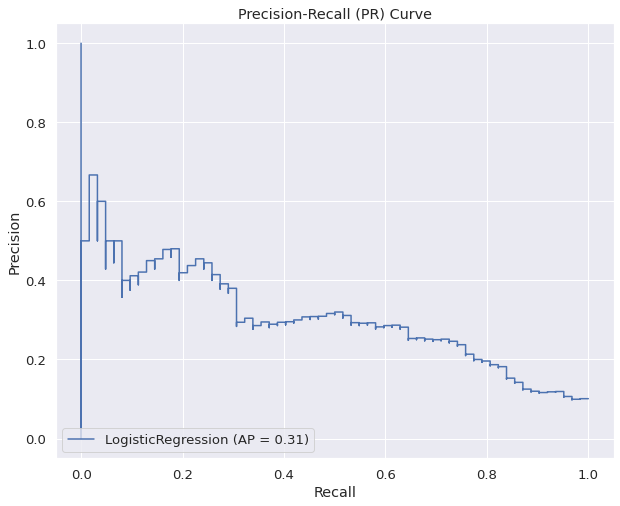

In [ ]:
best_model_num = 5
lr_best_model = models[best_model_num]
plot_roc_pr_curves(X_val, y_val, lr_best_model)

##### Ensemble-based models: Gradient Boosting and Random Forest

In [ ]:
ensemble_results = {}
ensemble_models = {}

**Gradient Boosting Classifier**

**Baseline scikit-learn settings**

n_estimators = 100 (number of trees)

max_depth = 3

min_samples_split = 2

min_samples_leaf = 1

subsample = 1.0


learning_rate = 0.1 (shrinkage)

subsample = 1

In [ ]:
# Baseline model
gb_baseline = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, min_samples_split = 2, 
                                     min_samples_leaf = 1, subsample = 1, max_features = "sqrt", random_state = seed)
gb_baseline.fit(X_train, y_train)

ensemble_results = validation_results(gb_baseline, X_val, y_val, "GB baseline", ensemble_results)
ensemble_models["GB baseline"] = gb_baseline

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
param_1 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1]}
param_2 = {'learning_rate':  [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]}
param_3 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 'max_depth': [2, 3, 4]}
param_4 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 
              'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 
             'max_depth': [2, 3, 4], 
             'max_features': [3, 4, 5]}

In [ ]:
# GBM with param_1
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                                             n_estimators = 100,
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_1, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'mean_fit_time': array([0.76812143, 0.74203987, 0.71826243, 0.73315449, 0.72173481,
         0.7242548 , 0.77015347, 0.68695211, 0.72392235, 0.727596  ]),
  'mean_score_time': array([0.00849524, 0.00971875, 0.00684199, 0.00487394, 0.00972419,
         0.00723095, 0.00729246, 0.00490851, 0.00925169, 0.00483565]),
  'mean_test_score': array([0.90767679, 0.90767679, 0.90821298, 0.90499294, 0.90016288,
         0.89748191, 0.89373   , 0.8883551 , 0.88245265, 0.87815734]),
  'param_learning_rate': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75,
                     1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.001},
   {'learning_rate': 0.005},
   {'learning_rate': 0.01},
   {'learning_rate': 0.05},
   {'learning_rate': 0.1},
   {'learning_rate': 0.15},
   {'learning_rate': 0.25},
   {'learning_rate': 0.5},
 

In [ ]:
# GBM with param_2
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_2, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'mean_fit_time': array([ 0.80385108,  1.86982436,  3.66470661,  5.49602499,  7.28110437,
          9.34193163, 11.04867024, 12.90092034,  0.79269075,  2.03497548,
          3.5569386 ,  5.41487422,  7.22817769,  9.04983363, 10.68131571,
         12.50484438,  0.76833115,  1.8614872 ,  3.60518193,  5.41434064,
          7.14322653,  9.02235894, 10.78223476, 12.58437762,  0.73507576,
          1.80348425,  3.6399703 ,  5.45742502,  7.20848207,  9.02273726,
         10.79214177, 12.38264432,  0.76060824,  1.90094395,  3.66658082,
          5.45248165,  7.2040494 ,  8.91513801, 10.79597673, 12.3544477 ,
          0.72639518,  1.87007132,  3.68911433,  5.45572081,  7.21152325,
          8.6380528 ,  9.14391665,  9.5638279 ,  0.74494867,  1.84119101,
          3.68012867,  5.16846571,  5.56914439,  5.88037949,  6.39539332,
          6.74204106,  0.80044041,  1.81451907,  2.75351624,  3.20300345,
          3.56082745,  3.97759857,  4.46912289,  4.88188319,  0.74143739,
          1.65648761,

In [ ]:
# GBM with param_3
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_3, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'mean_fit_time': array([ 0.55755725,  1.35919914,  2.62634678,  3.92554903,  5.26916986,
          6.52670426,  7.82732263,  9.14636011,  0.7492084 ,  1.80978427,
          3.664148  ,  5.47036867,  7.20786896,  9.00614882, 10.69753294,
         12.59688935,  0.96149731,  2.40733852,  4.74716468,  7.11761436,
          9.44218268, 11.7774384 , 14.08791661, 16.78264432,  0.54057169,
          1.34208202,  2.5797441 ,  3.91919365,  5.24838495,  6.51974773,
          7.76613255,  9.10977168,  0.74340038,  1.8365314 ,  3.59933472,
          5.32844019,  7.18666973,  8.74080305, 10.63741055, 12.37378597,
          0.9209013 ,  2.36472812,  4.63771033,  6.94418659,  9.12940412,
         11.51700802, 13.74665213, 16.32363071,  0.53937783,  1.31880393,
          2.61644182,  3.8940012 ,  5.20800066,  6.56618114,  7.72422848,
          8.91303854,  0.74153905,  1.85165286,  3.57189484,  5.36069646,
          7.08668966,  8.83047018, 10.67468605, 12.33862748,  0.96811514,
          2.35126925,

In [ ]:
# GBM with param_4
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, 
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_4, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'mean_fit_time': array([ 0.34349384,  0.90773182,  1.70299344,  2.52658825,  3.35153232,
          4.09766269,  4.99263449,  5.83451648,  0.37915831,  0.93215151,
          1.80819755,  2.71450682,  3.70817738,  4.58522096,  5.41492763,
          6.17938991,  0.3963562 ,  0.99153757,  1.90456262,  2.89121094,
          3.8324132 ,  4.82443609,  5.84273777,  6.66167445,  0.43418236,
          1.07528892,  2.16222067,  3.25820537,  4.34214869,  5.26636844,
          6.27561603,  7.34661674,  0.47096324,  1.18096824,  2.41254568,
          3.62689681,  4.65766521,  5.83843565,  6.89880619,  8.10412865,
          0.52268682,  1.26817703,  2.56076856,  3.82172794,  4.97306094,
          6.26574616,  7.67073259,  8.81620607,  0.55103121,  1.36564794,
          2.77859983,  4.09112115,  5.499438  ,  6.77235384,  8.16359248,
          9.48670006,  0.62885542,  1.52311068,  3.06873813,  4.58391724,
          6.02955937,  7.51341009,  8.93942118, 10.37589288,  0.67659287,
          1.6637249 ,

In [ ]:
gb_model_param1 = GradientBoostingClassifier(learning_rate = 0.001, random_state = seed)
gb_model_param1.fit(X_train, y_train)
predictions = gb_model_param1.predict(X_val)
print(metrics.classification_report(y_val, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       570
           1       0.00      0.00      0.00        52

    accuracy                           0.92       622
   macro avg       0.46      0.50      0.48       622
weighted avg       0.84      0.92      0.88       622



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gb_model_param2 = GradientBoostingClassifier(learning_rate = 0.005,n_estimators = 500, random_state = seed)
gb_model_param2.fit(X_train, y_train)
predictions = gb_model_param2.predict(X_val)
print(metrics.classification_report(y_val, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.92      1.00      0.95       570
           1       0.00      0.00      0.00        52

    accuracy                           0.91       622
   macro avg       0.46      0.50      0.48       622
weighted avg       0.84      0.91      0.87       622



In [ ]:
gb_model_param3 = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 1500, max_depth = 4, random_state = seed)
gb_model_param3.fit(X_train, y_train)
predictions = gb_model_param3.predict(X_val)
print(metrics.classification_report(y_val, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.92      1.00      0.95       570
           1       0.00      0.00      0.00        52

    accuracy                           0.91       622
   macro avg       0.46      0.50      0.48       622
weighted avg       0.84      0.91      0.87       622



In [ ]:
gb_model_param4 = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, max_features = 5,
                                             n_estimators = 250, random_state = seed)
gb_model_param4.fit(X_train, y_train)
predictions = gb_model_param4.predict(X_val)
print(metrics.classification_report(y_val, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.92      1.00      0.95       570
           1       0.00      0.00      0.00        52

    accuracy                           0.91       622
   macro avg       0.46      0.50      0.48       622
weighted avg       0.84      0.91      0.87       622



In [ ]:
gb_best_model = gb_model_param2
ensemble_models["GB best model"] = gb_best_model

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state = seed)

# Look at parameters in rf 
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 212,
 'verbose': 0,
 'warm_start': False}


In [ ]:
rf_baseline = RandomForestClassifier(random_state = seed)
rf_baseline.fit(X_train, y_train)

ensemble_results = validation_results(rf_baseline, X_val, y_val, "RF baseline", ensemble_results)
ensemble_models["RF baseline"] = rf_baseline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
# Random search grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node 
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create random grid
random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Random search training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation
# Search across 100 different combinations, and use all available cores
rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state = seed, 
                              n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random_model = rf_random.best_estimator_

ensemble_results = validation_results(rf_random_model, X_val, y_val, "RF best model (Random Search)", ensemble_results)
ensemble_models["RF best model (Random Search)"] = rf_random_model

# View best parameters
rf_random.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 2000}

In [ ]:
param_grid = {
    'bootstrap':[True],
    'max_depth': [9, 10, 11], 
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4], 
    'n_estimators': [400, 500, 600, 700, 800, 900]
}

In [ ]:
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = model_selection.GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit grid to search data
grid_search.fit(X_train, y_train)

# Best model
rf_grid_model = grid_search.best_estimator_

ensemble_results = validation_results(rf_grid_model, X_val, y_val, "RF best model (Grid Search)", ensemble_results)
ensemble_models["Rf best model (Grid Search)"] = rf_grid_model

grid_search.best_params_

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 64.4min
[Parallel(n_jobs=-1)]: Done 3456 out of 3456 | elapsed: 68.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 9,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 400}

In [ ]:
ensemble_results

{'GB baseline': {'accuracy': 0.9131832797427653,
  'average_precision': 0.20164463653024625,
  'balanced_accuracy': 0.5244601889338731,
  'f1': 0.09999999999999999,
  'precision': 0.375,
  'recall': 0.057692307692307696,
  'roc_auc': 0.7345816464237517},
 'RF baseline': {'accuracy': 0.9131832797427653,
  'average_precision': 0.24226132760540198,
  'balanced_accuracy': 0.4982456140350877,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'roc_auc': 0.7730431848852902},
 'RF best model (Grid Search)': {'accuracy': 0.9147909967845659,
  'average_precision': 0.24415535778671305,
  'balanced_accuracy': 0.49912280701754386,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'roc_auc': 0.7691632928475034},
 'RF best model (Random Search)': {'accuracy': 0.9131832797427653,
  'average_precision': 0.26250817098781887,
  'balanced_accuracy': 0.4982456140350877,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'roc_auc': 0.7848515519568151}}

Visualize model performance on validation set.

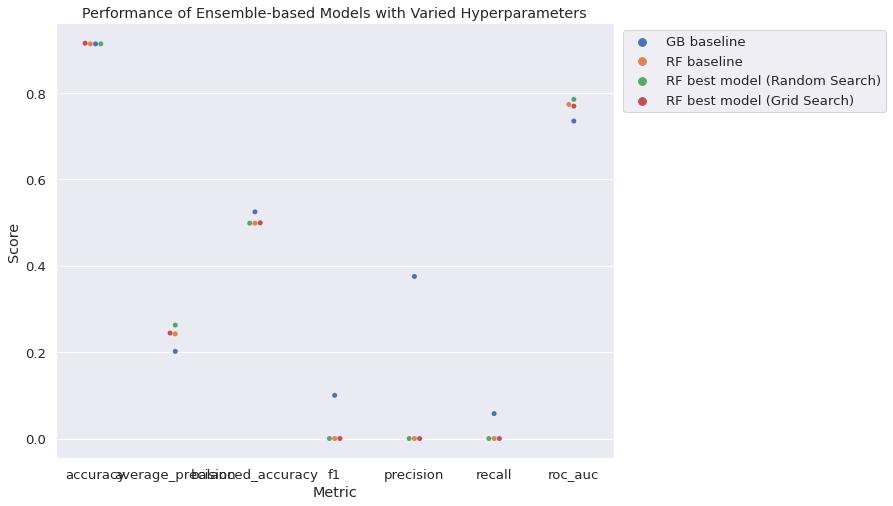

In [ ]:
plot_validation_results(ensemble_results, "Ensemble-based")

Best ensemble-based model.

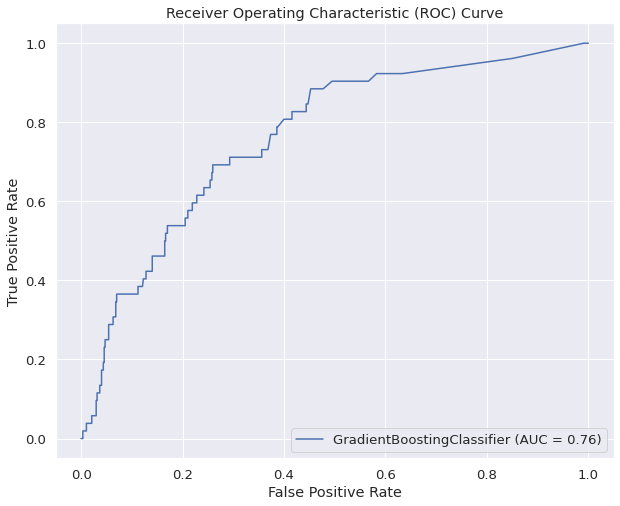

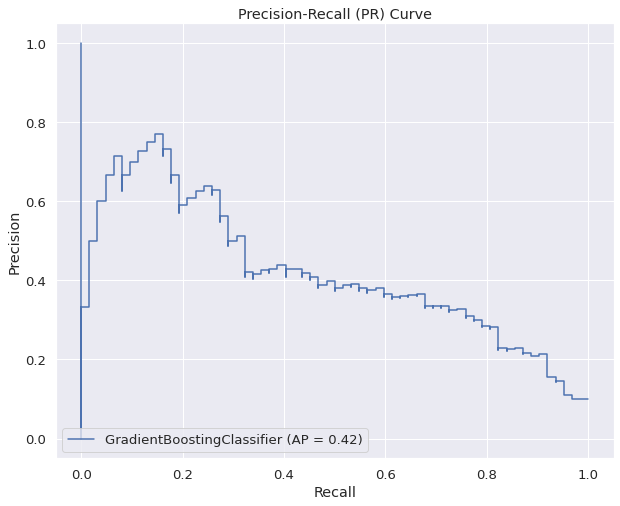

In [ ]:
plot_roc_pr_curves(X_val, y_val, gb_best_model)

In [ ]:
def test_model(clf, X_test, y_test, fig_size=(10,8)):
    # clf: trained classifier (i.e. after using fit function)
    y_pred = clf.predict(X_test)
    y_score = clf.decision_function(X_test)

    # print out stats
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Model accuracy: %.3f\n" % accuracy)

    # precision, recall, and f1-score is usually reported for class 1 (in binary case)
    # recall of positive class (1) = sensitivity
    # recall of negative class (0) = specificity
    # preicion of positive class (1) = PPV
    # precision of negative class (0) = NPV
    print(metrics.classification_report(y_test,y_pred))

    # confusion matrix
    cm_disp = metrics.plot_confusion_matrix(clf, X_test, y_test)  

    # ROC Curve and AUC
    auroc = metrics.roc_auc_score(y_test, y_score)
    fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X, y, ax=ax_roc)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve")

    # PR Curve and AP (average precision)
    fig, ax_pr = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pr)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title("Precision-Recall (PR) Curve")

    """
    # alternatively we can report the auc of the pr curve
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    pr_auc = metrics.auc(precision, recall)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, name="Precision-Recall Curve: AP=%.3f" % ap)
    """

    plt.show()

Model accuracy: 0.899

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       560
           1       0.43      0.05      0.09        62

    accuracy                           0.90       622
   macro avg       0.67      0.52      0.52       622
weighted avg       0.86      0.90      0.86       622



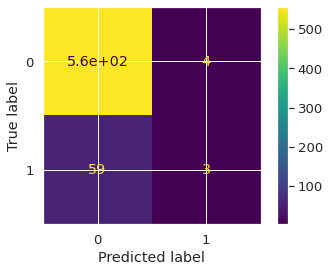

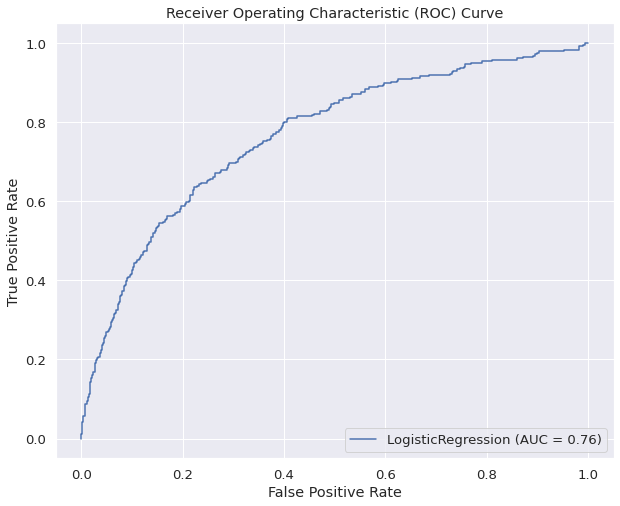

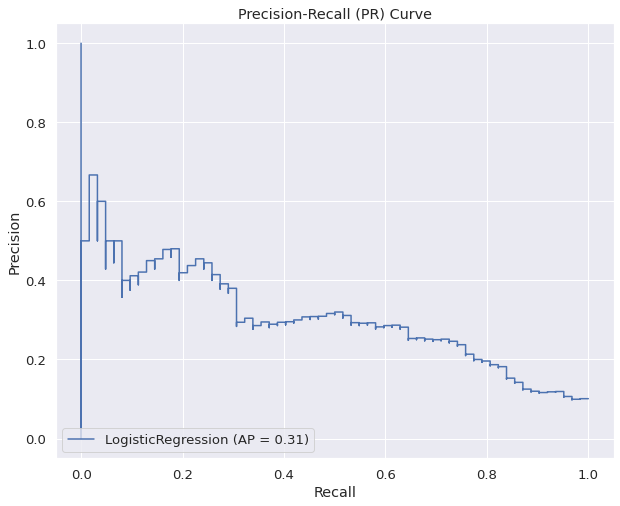

In [ ]:
test_model(lr_best_model, X_test, y_test)

Model accuracy: 0.905

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       560
           1       0.71      0.08      0.14        62

    accuracy                           0.91       622
   macro avg       0.81      0.54      0.55       622
weighted avg       0.89      0.91      0.87       622



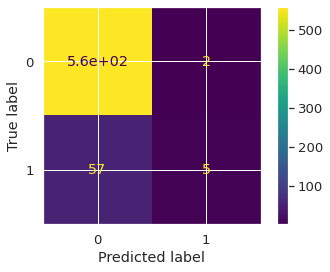

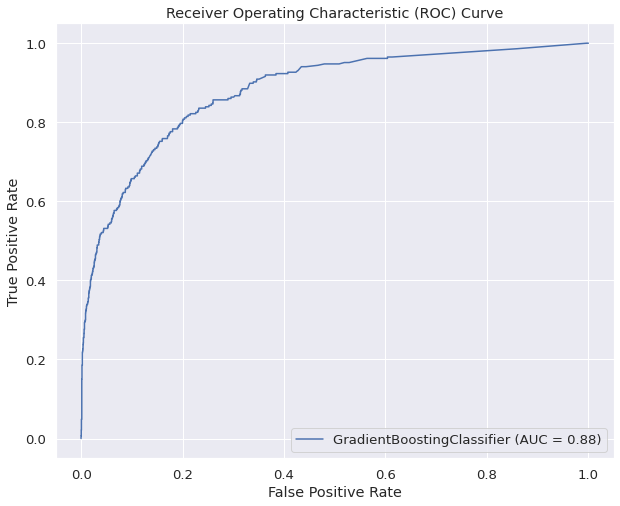

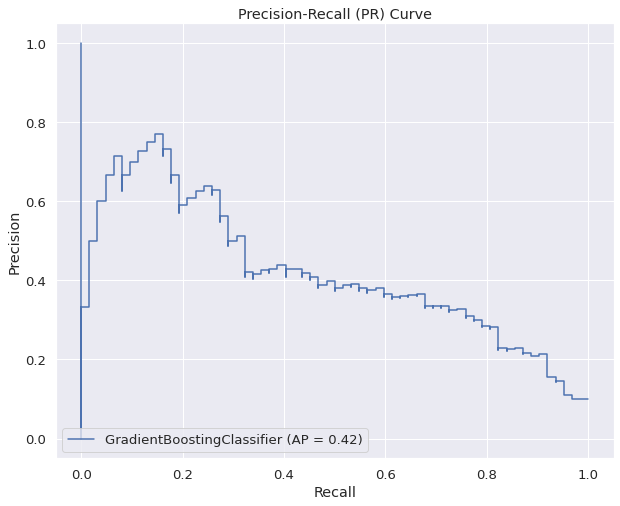

In [ ]:
test_model(gb_best_model, X_test, y_test)

### External validation: MIMIC

In [ ]:
X_mimic = mimic.drop(columns=["subject_id", "readmit"]).astype("float")
X_mimic = X_mimic[feature_order]
y_mimic = mimic[["readmit"]]

In [ ]:
X_mimic.describe()

,age,gender,ethnicity,icu_los,hospital_los,admit_ed,ecg,xray,cxr,mri,ct,intub_days,extub_hrs,diuretics,antihypertensives,inotrope_pressor,sedatives,alt_last,ast_last,hco3_last,bnp_last,bun_last,ck_last,cr_last,crp_last,dbili_last,esr_last,fio2_last,inr_last,hr_last,k_last,lac_last,ph_last,lipase_last,na_last,map_last,pao2_last,paco2_last,plt_last,sao2_last,spo2_last,temp_last,tbili_last,wbc_last,trop_last,hgb_last,gcs_last,pafio2_last,alt_max,ast_max,hco3_max,bnp_max,bun_max,ck_max,cr_max,crp_max,esr_max,dbili_max,hr_max,k_max,inr_max,cortisol_max,lipase_max,lac_max,map_max,ph_max,na_max,paco2_max,pao2_max,spo2_max,sao2_max,tbili_max,trop_max,temp_max,wbc_max,gcs_max,gcs_min,hco3_min,cortisol_min,hr_min,inr_min,k_min,map_min,ph_min,na_min,paco2_min,pao2_min,plt_min,spo2_min,sao2_min,temp_min,wbc_min,hgb_min,hco3_high,bnp_high,bun_high,inflamm_marker,glu_high,hr_high,k_high,na_high,lac_high,temp_high,trop_high,wbc_high,map_high,hco3_low,hgb_low,map_low,hr_low,k_low,plt_low,na_low,wbc_low,temp_low
count,13841.00000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.00000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.0,13841.000000,13841.000000,13841.000000,13841.000000,13841.000000,13841.00000,13841.000000,13841.000000,13841.000000
mean,61.37649,0.592443,2.323243,4.553740,5.380658,0.481902,0.714905,1.958746,1.780363,0.129398,0.455820,1.083737,29.481107,1.638321,0.874865,0.649953,3.117766,122.064795,163.248602,25.137085,7354.401899,23.556698,938.445111,1.245960,90.475271,3.571843,52.329114,0.479609,1.351486,77.193373,4.043098,1.798788,7.402469,104.175814,138.547528,59.666667,80.057191,283.060841,215.813610,95.744521,95.096105,98.262877,1.909467,11.062556,0.609824,10.368121,13.955422,174.662497,257.548387,426.221337,26.812505,7577.321203,30.476577,2356.591896,1.613465,96.782863,52.911392,3.972782,112.692128,4.765570,1.636229,30.662053,166.178938,2.985347,59.666667,7.451130,141.598232,533.870741,737.127562,99.765421,97.435633,2.464539,0.836134,99.847174,15.223640,14.549527,8.776533,21.340568,25.164558,63.105845,1.22599,3.585710,59.666667,7.308109,135.068848,34.756907,97.279569,168.324081,87.766223,93.633883,96.609441,8.908706,9.563207,1.087310,0.044525,4.142640,0.047426,0.194344,25.216389,1.032197,3.358593,1.980493,1.487310,0.257288,2.988325,0.0,1.840998,1.335635,0.000162,1.478469,0.023562,1.59376,0.509669,0.294118,1.955720
std,17.25083,0.491398,2.230889,5.750555,6.557731,0.499690,1.157253,3.339523,3.072278,0.400257,1.094628,2.932600,73.957472,3.277435,1.758038,1.547677,4.113105,350.222910,648.983497,4.460144,2217.563214,19.933575,2783.753746,1.329155,15.254663,1.541455,5.211802,0.123015,0.604015,15.975654,0.506291,1.525518,0.086581,126.079957,4.372983,0.107744,7.107170,12019.207960,129.962268,2.923979

Model accuracy: 0.940

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13039
           1       0.10      0.00      0.01       802

    accuracy                           0.94     13841
   macro avg       0.52      0.50      0.49     13841
weighted avg       0.89      0.94      0.91     13841



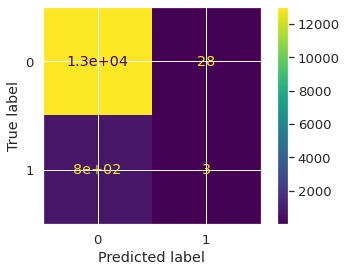

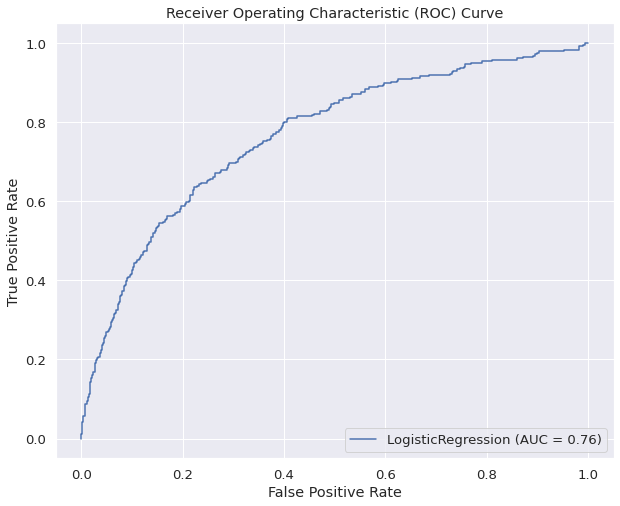

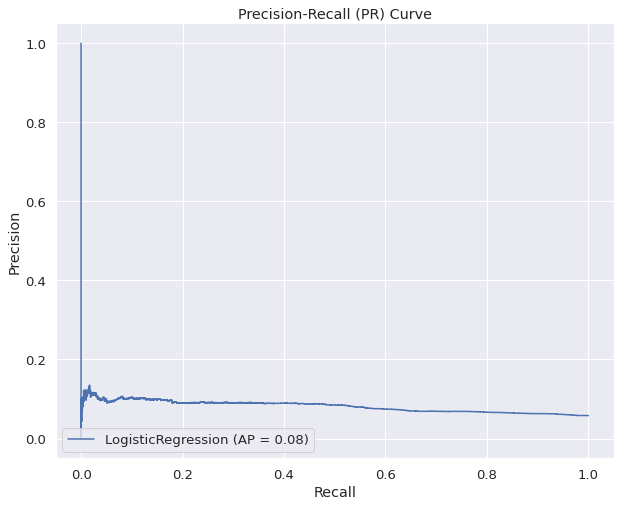

In [ ]:
test_model(lr_best_model, X_mimic, y_mimic)

Model accuracy: 0.918

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     13039
           1       0.08      0.04      0.05       802

    accuracy                           0.92     13841
   macro avg       0.51      0.51      0.51     13841
weighted avg       0.89      0.92      0.90     13841



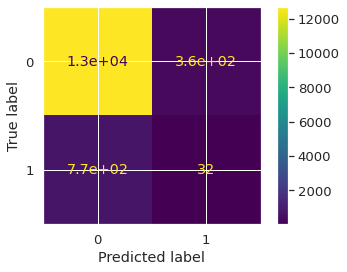

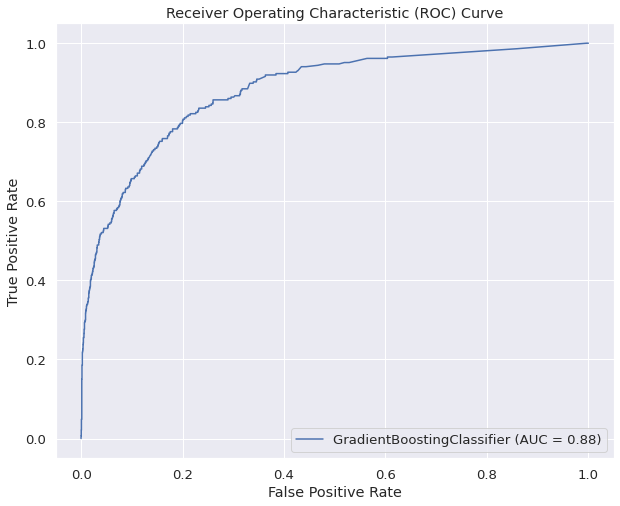

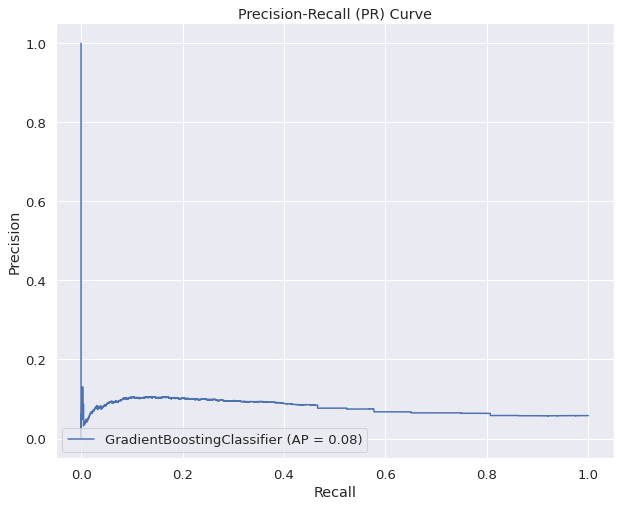

In [ ]:
test_model(gb_best_model, X_mimic, y_mimic)

### SWIFT metrics.

In [ ]:
X_test = X_test.reset_index()
del X_test['index']
y_test = y_test.reset_index()
del y_test['index']

X_mimic = X_mimic.reset_index()
del X_mimic['index']
y_mimic = y_mimic.reset_index()
del y_mimic['index']


In [ ]:
starr_swift = []
for i in range(X_test.shape[0]):
  score = 0
  if X_test['admit_ed'][i] == 0:
    score += 8
  else:
    score += 0
  if X_test['icu_los'][i] > 10: 
    score += 14
  elif X_test['icu_los'][i] >= 2 and X_test['icu_los'][i] <= 10:
    score += 1
  else: 
    score += 0
  if X_test['pafio2_last'][i] < 100:
    score += 13
  elif X_test['pafio2_last'][i] < 150:
    score += 10
  elif X_test['pafio2_last'][i] < 400: 
    score += 5
  else:
    score += 0
  if X_test['gcs_last'][i] < 8:
    score += 24
  elif X_test['gcs_last'][i] < 11:
    score += 14
  elif X_test['gcs_last'][i] < 14:
    score += 6
  else: 
    score += 0 
  if X_test['paco2_last'][i] > 45:
    score += 5
  else: 
    score += 0
  starr_swift.append(score)

mimic_swift = []
for i in range(X_mimic.shape[0]):
  score = 0
  if X_mimic['admit_ed'][i] == 0:
    score += 8
  else:
    score += 0
  if X_mimic['icu_los'][i] > 10: 
    score += 14
  elif X_mimic['icu_los'][i] >= 2 and X_mimic['icu_los'][i] <= 10:
    score += 1
  else: 
    score += 0
  if X_mimic['pafio2_last'][i] < 100:
    score += 13
  elif X_mimic['pafio2_last'][i] < 150:
    score += 10
  elif X_mimic['pafio2_last'][i] < 400: 
    score += 5
  else:
    score += 0
  if X_mimic['gcs_last'][i] < 8:
    score += 24
  elif X_mimic['gcs_last'][i] < 11:
    score += 14
  elif X_mimic['gcs_last'][i] < 14:
    score += 6
  else: 
    score += 0
  if X_mimic['paco2_last'][i] > 45:
    score += 5
  else: 
    score += 0
  mimic_swift.append(score)

starr_swift = pd.DataFrame(starr_swift)
mimic_swift = pd.DataFrame(mimic_swift)


In [ ]:
starr_swift.columns = ['score']
mimic_swift.columns = ['score']

In [ ]:
starr_swift['outcome'] = [1 if x >= 15 else 0 for x in starr_swift['score']]
mimic_swift['outcome'] = [1 if x >= 15 else 0 for x in mimic_swift['score']]

#data[col_name] = [1 if x >= 0 else 0 for x in data[col]]

In [ ]:
def swift_metrics(y_pred, y_test, fig_size=(10,8)):
# precision, recall, and f1-score is usually reported for class 1 (in binary case)
    # recall of positive class (1) = sensitivity
    # recall of negative class (0) = specificity
    # preicion of positive class (1) = PPV
    # precision of negative class (0) = NPV
    print(metrics.classification_report(y_test,y_pred))

    # confusion matrix
    #cm_disp = metrics.plot_confusion_matrix(y_test, y_pred)  

    # ROC Curve and AUC
    #auroc = metrics.roc_auc_score(y_test, y_pred)
    #fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    #roc_disp = metrics.plot_roc_curve(y_test, y_pred, ax=ax_roc)
    #ax_roc.set_xlabel("False Positive Rate")
    #ax_roc.set_ylabel("True Positive Rate")
    #ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve")

    # PR Curve and AP (average precision)
    #fig, ax_pr = plt.subplots(1,1,figsize=fig_size)
    #pr_disp = metrics.plot_precision_recall_curve(y_test, y_pred, ax=ax_pr)
    #ax_pr.set_xlabel("Recall")
    #ax_pr.set_ylabel("Precision")
    #ax_pr.set_title("Precision-Recall (PR) Curve")

    """
    # alternatively we can report the auc of the pr curve
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    pr_auc = metrics.auc(precision, recall)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, name="Precision-Recall Curve: AP=%.3f" % ap)
    """

    #plt.show()

In [ ]:
swift_metrics(starr_swift['outcome'], y_test)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       560
           1       0.23      0.53      0.33        62

    accuracy                           0.78       622
   macro avg       0.59      0.67      0.60       622
weighted avg       0.87      0.78      0.81       622



In [ ]:
swift_metrics(mimic_swift['outcome'], y_mimic)

              precision    recall  f1-score   support

           0       0.94      0.58      0.72     13039
           1       0.06      0.41      0.10       802

    accuracy                           0.57     13841
   macro avg       0.50      0.50      0.41     13841
weighted avg       0.89      0.57      0.69     13841



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
print('roc_auc_score for STARR SWIFT: ', roc_auc_score(y_test, starr_swift['outcome']))
print('precision_recall_score for STARR SWIFT: ', precision_recall_fscore_support(y_test, starr_swift['outcome'], average = 'micro'))
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, starr_swift['outcome'])

roc_auc_score for STARR SWIFT:  0.6697004608294931
precision_recall_score for STARR SWIFT:  (0.7797427652733119, 0.7797427652733119, 0.7797427652733119, None)


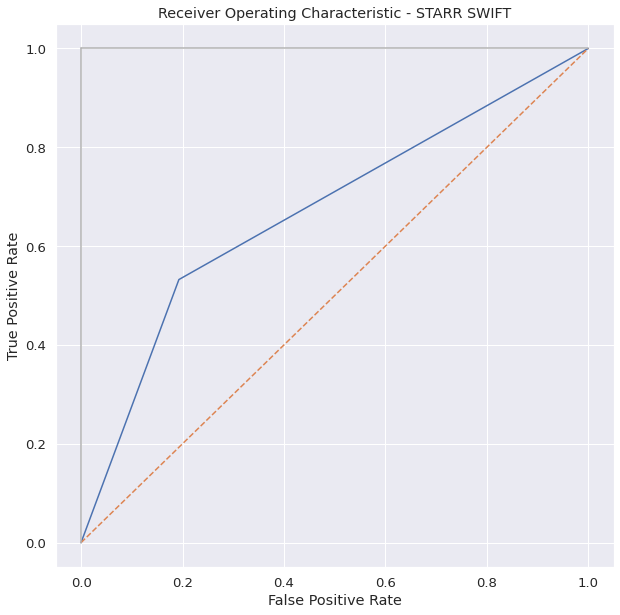

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - STARR SWIFT')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print('roc_auc_score for MIMIC SWIFT: ', roc_auc_score(y_mimic, mimic_swift['outcome']))
print('precision_recall_score for MIMIC SWIFT: ', precision_recall_fscore_support(y_mimic, mimic_swift['outcome'], average = 'micro'))

false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_mimic, mimic_swift['outcome'])

roc_auc_score for MIMIC SWIFT:  0.4978592899605423
precision_recall_score for MIMIC SWIFT:  (0.5742359656094213, 0.5742359656094213, 0.5742359656094213, None)


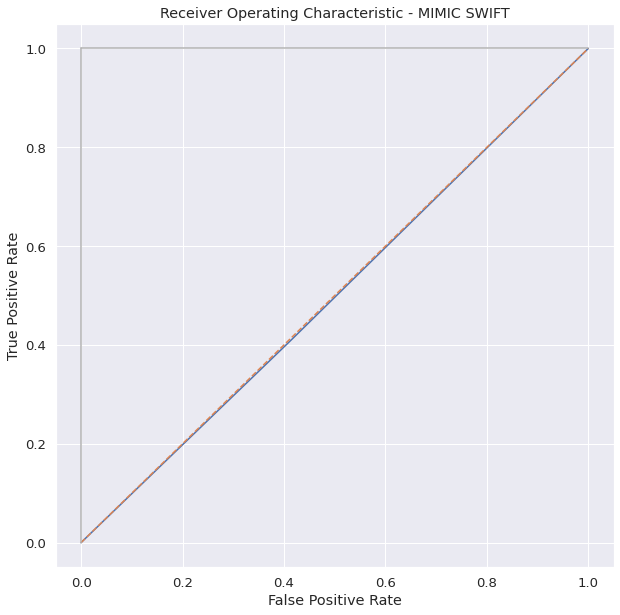

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - MIMIC SWIFT')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
X_test, y_test
X_mimic, y_mimic

In [ ]:
# X = features, y = readmit (outcome)

# define model
model = RandomForestClassifier()

# define imputer
imputer = IterativeImputer() # default is described below
#imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# define pipeline
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])

# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# fit on the dataset
#imputer.fit(X)
# transform the dataset
#Xtrans = imputer.transform(X)


### Write out files.

In [ ]:
### Write results to csv file.
import csv

# name of csv file 
filename = "starr_final.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the header
    csvwriter.writerow(starr.columns) 
        
    # writing the data rows 
    for i in range(starr.shape[0]):
        csvwriter.writerow(starr.iloc[i])

In [ ]:
### Write results to csv file.
# name of csv file 
filename = "mimic_final.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the header
    csvwriter.writerow(mimic.columns) 
        
    # writing the data rows 
    for i in range(mimic.shape[0]):
        csvwriter.writerow(mimic.iloc[i])